# Category 3

Convolution Neural Network (합성곱 신경망)를 활용한 이미지 분류 (Image Classification)

말과 사람을 구분하는 **이진 분류 (Binary Classification)** 문제입니다.

**Train / Validation dataset이 각각 주어진 경우**

This task requires you to create a classifier for horses or humans using
the provided dataset. 

Please make sure your final layer has 2 neurons, activated by softmax 
as shown. Do not change the provided output layer, or tests may fail.

IMPORTANT: Please note that the test uses images that are 300x300 with 
3 bytes color depth so be sure to design your input layer to accept
these, or the tests will fail.

-------------------------------

이 작업에서는 다음을 사용하여 말이나 사람을위한 분류기를 만들어야합니다.

최종 레이어에 softmax에 의해 활성화 된 2 개의 뉴런이 있는지 확인하십시오

중요 : 테스트에는 **300x300 크기의 이미지**가 사용됩니다.
3 바이트 색상 심도이므로 입력 레이어를 수용하도록 설계하십시오

In [ ]:
# 문제에서 지정해야할 Node의 개수 2개 -> Softmax   /   1개 -> Sigmoid

# 1 .import

In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# 2. Load dataset

In [2]:
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"

urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')

local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()

urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')
local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

**데이터셋 시각화**

Found 1027 images belonging to 2 classes.
(128, 300, 300, 3) (128, 2)
[1. 0.]


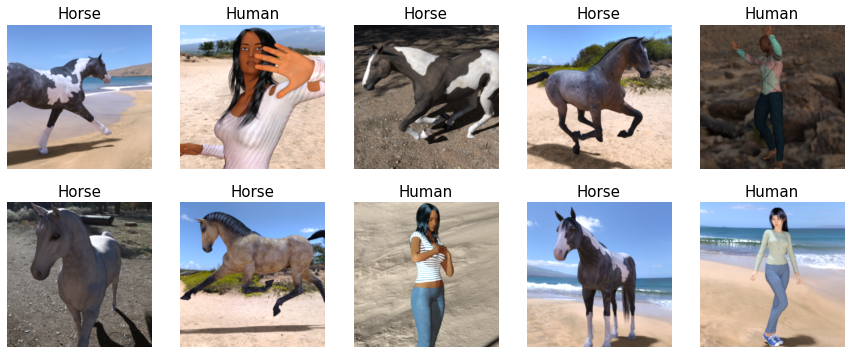

In [3]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Horse',
    1: 'Human', 
}

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory('tmp/horse-or-human/', 
                                                          batch_size=128, 
                                                          target_size=(300, 300), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

# 3. Preprocessing (ImageDataGenrator)

데이터셋의 경로를 지정

In [4]:
TRAINING_DIR = 'tmp/horse-or-human/'
VALIDATION_DIR = 'tmp/validation-horse-or-human'

`ImageDataGenerator`를 정의합니다.

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절해 주세요

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

In [5]:
training_datagen = ImageDataGenerator(
    rescale= 1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest', 
)

In [6]:
validation_datagen = ImageDataGenerator(
    rescale= 1. / 255.0
)

ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다.
* `target_size`를 정의합니다. (300 x 300). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 3개 이상의 클래스인 경우 'categorical', 이진 분류의 경우 'binary'를 지정합니다.
* `subset`을 지정합니다. (training / validation)

In [7]:
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(300, 300),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1027 images belonging to 2 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

Found 256 images belonging to 2 classes.


# 4. 모델 정의 (Sequential)

In [9]:
model = Sequential([
                    Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(32, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3, 3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Flatten(),
                    Dropout(0.5),
                    Dense(128, activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(2, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

# 5. Compile

In [11]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['acc'])

# 6. ModelCheckPoint

In [12]:
checkpoint_path = 'my_checkpoint.ckpt'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only = True,
                             monitor='val_loss',
                             verbose=1)

# 7. fit

In [13]:
model.fit(train_generator,
          validation_data =(validation_generator),
          epochs = 25,
          callbacks = [checkpoint])

Epoch 1/25
33/33 [==============================] - 27s 704ms/step - loss: 0.6662 - acc: 0.5910 - val_loss: 1.1985 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.19848, saving model to my_checkpoint.ckpt
Epoch 2/25
33/33 [==============================] - 23s 708ms/step - loss: 0.5606 - acc: 0.6952 - val_loss: 1.9199 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 1.19848
Epoch 3/25
33/33 [==============================] - 23s 705ms/step - loss: 0.4683 - acc: 0.7683 - val_loss: 3.2240 - val_acc: 0.5078

Epoch 00003: val_loss did not improve from 1.19848
Epoch 4/25
33/33 [==============================] - 23s 710ms/step - loss: 0.4176 - acc: 0.7887 - val_loss: 3.4179 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 1.19848
Epoch 5/25
33/33 [==============================] - 24s 712ms/step - loss: 0.3531 - acc: 0.8247 - val_loss: 3.2861 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 1.19848
Epoch 6/25
33/33 [=====================

# 8. Load Weights

In [14]:
model.load_weights(checkpoint_path)

[0] [1] 은 binary

[0, 1] [1, 0] 은 categorical

ImageDataGenerator은 자동 원핫인코딩 처리여서 categorical로 해야함